17.1 Getting the Data

ImportError: lxml not found, please install it
Anacoda showd it already installed but ran
conda install -c anaconda lxml
and reinstalled.



In [32]:
import pandas as pd


url = 'https://en.wikipedia.org/wiki/Historical_rankings_of_presidents_of_the_United_States'

pres_dfs = pd.read_html(url)

df = pres_dfs[-10]





In [33]:
# regular expression removes all empty spaces
df = (df
.iloc[1:-1]
.rename(columns={'Political party':'Party'})
.assign(Party = lambda df_: df_
    .Party
    .str.replace(r'\[.*\]', '')
    .astype('category'))
)

# export to csv
df.to_csv('siena2018-pres.csv')

# save a parquet instead

df.to_parquet('siena2018')



C:\Users\wgrom\AppData\Local\Temp\ipykernel_10024\1912782997.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  .assign(Party = lambda df_: df_


In [41]:
df = pd.read_csv('siena2018-pres.csv', index_col=0)

df_p = pd.read_parquet('siena2018')



In [43]:
pd.set_option('display.max_rows', 10)              # REMOVELINE 
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'siena2018-pres.csv'
df = pd.read_csv(url, index_col=0)

In [42]:
df

,Seq.,President,Party,Bg,Im,Int,IQ,L,WR,AC,...,PL,RC,CAp,HE,EAp,DA,FPA,AM,EV,O
1,1,George Washington,Independent,7,7,1,10,1,6,2,...,18,1,1,1,1,2,2,1,2,1
2,2,John Adams,Federalist,3,14,4,4,24,14,32,...,28,17,4,13,15,19,13,16,10,14
3,3,Thomas Jefferson,Democratic-Republican,2,2,14,1,8,5,14,...,5,5,7,20,4,6,9,7,5,5
4,4,James Madison,Democratic-Republican,4,6,7,3,16,15,6,...,9,10,6,14,7,11,19,11,8,7
5,5,James Monroe,Democratic-Republican,9,15,11,18,6,16,7,...,12,8,11,9,9,10,5,6,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,41,George H. W. Bush,Republican,10,28,18,19,20,27 (tie),13,...,21,20,29,28,19,26,10,17,21,21
41,42,Bill Clinton,Democratic,21,13,39,8,11,17,3,...,13,18,10,5,12,9,18,30,14,15
42,43,George W. Bush,Republican,17,30,33,41,21,20,29,...,19,22,28,36,29,30,38,36,34,33
43,44,Barack Obama,Democratic,25,11 (tie),13,9,15,23,16,...,23,31,14,10,13,13,20,10,11,17


In [36]:
df.dtypes

Seq.         object
President    object
Party        object
Bg           object
Im           object
Int           int64
IQ            int64
L             int64
WR           object
AC           object
EAb          object
LA            int64
CAb           int64
OA            int64
PL            int64
RC           object
CAp           int64
HE            int64
EAp           int64
DA            int64
FPA           int64
AM            int64
EV            int64
O             int64
dtype: object

In [44]:
def tweak_siena_pres(df):
    def int64_to_uint8(df_):
        cols = df_.select_dtypes('int64')
        return (df_
                .astype({col:'uint8' for col in cols}))


    return (df
     .rename(columns={'Seq.':'Seq'})    # 1
     .rename(columns={k:v.replace(' ', '_') for k,v in
        {'Bg': 'Background',
         'PL': 'Party leadership', 'CAb': 'Communication ability',
         'RC': 'Relations with Congress', 'CAp': 'Court appointments',
         'HE': 'Handling of economy', 'L': 'Luck',
         'AC': 'Ability to compromise', 'WR': 'Willing to take risks',
         'EAp': 'Executive appointments', 'OA': 'Overall ability',
         'Im': 'Imagination', 'DA': 'Domestic accomplishments',
         'Int': 'Integrity', 'EAb': 'Executive ability',
         'FPA': 'Foreign policy accomplishments',
         'LA': 'Leadership ability',
         'IQ': 'Intelligence', 'AM': 'Avoid crucial mistakes',
         'EV': "Experts' view", 'O': 'Overall'}.items()})
     .astype({'Party':'category'})  # 2
     .pipe(int64_to_uint8)  # 3
     .assign(Average_rank=lambda df_:(df_.select_dtypes('uint8') # 4
                 .sum(axis=1).rank(method='dense').astype('uint8')),
             Quartile=lambda df_:pd.qcut(df_.Average_rank, 4,
                 labels='1st 2nd 3rd 4th'.split())
            )
    )

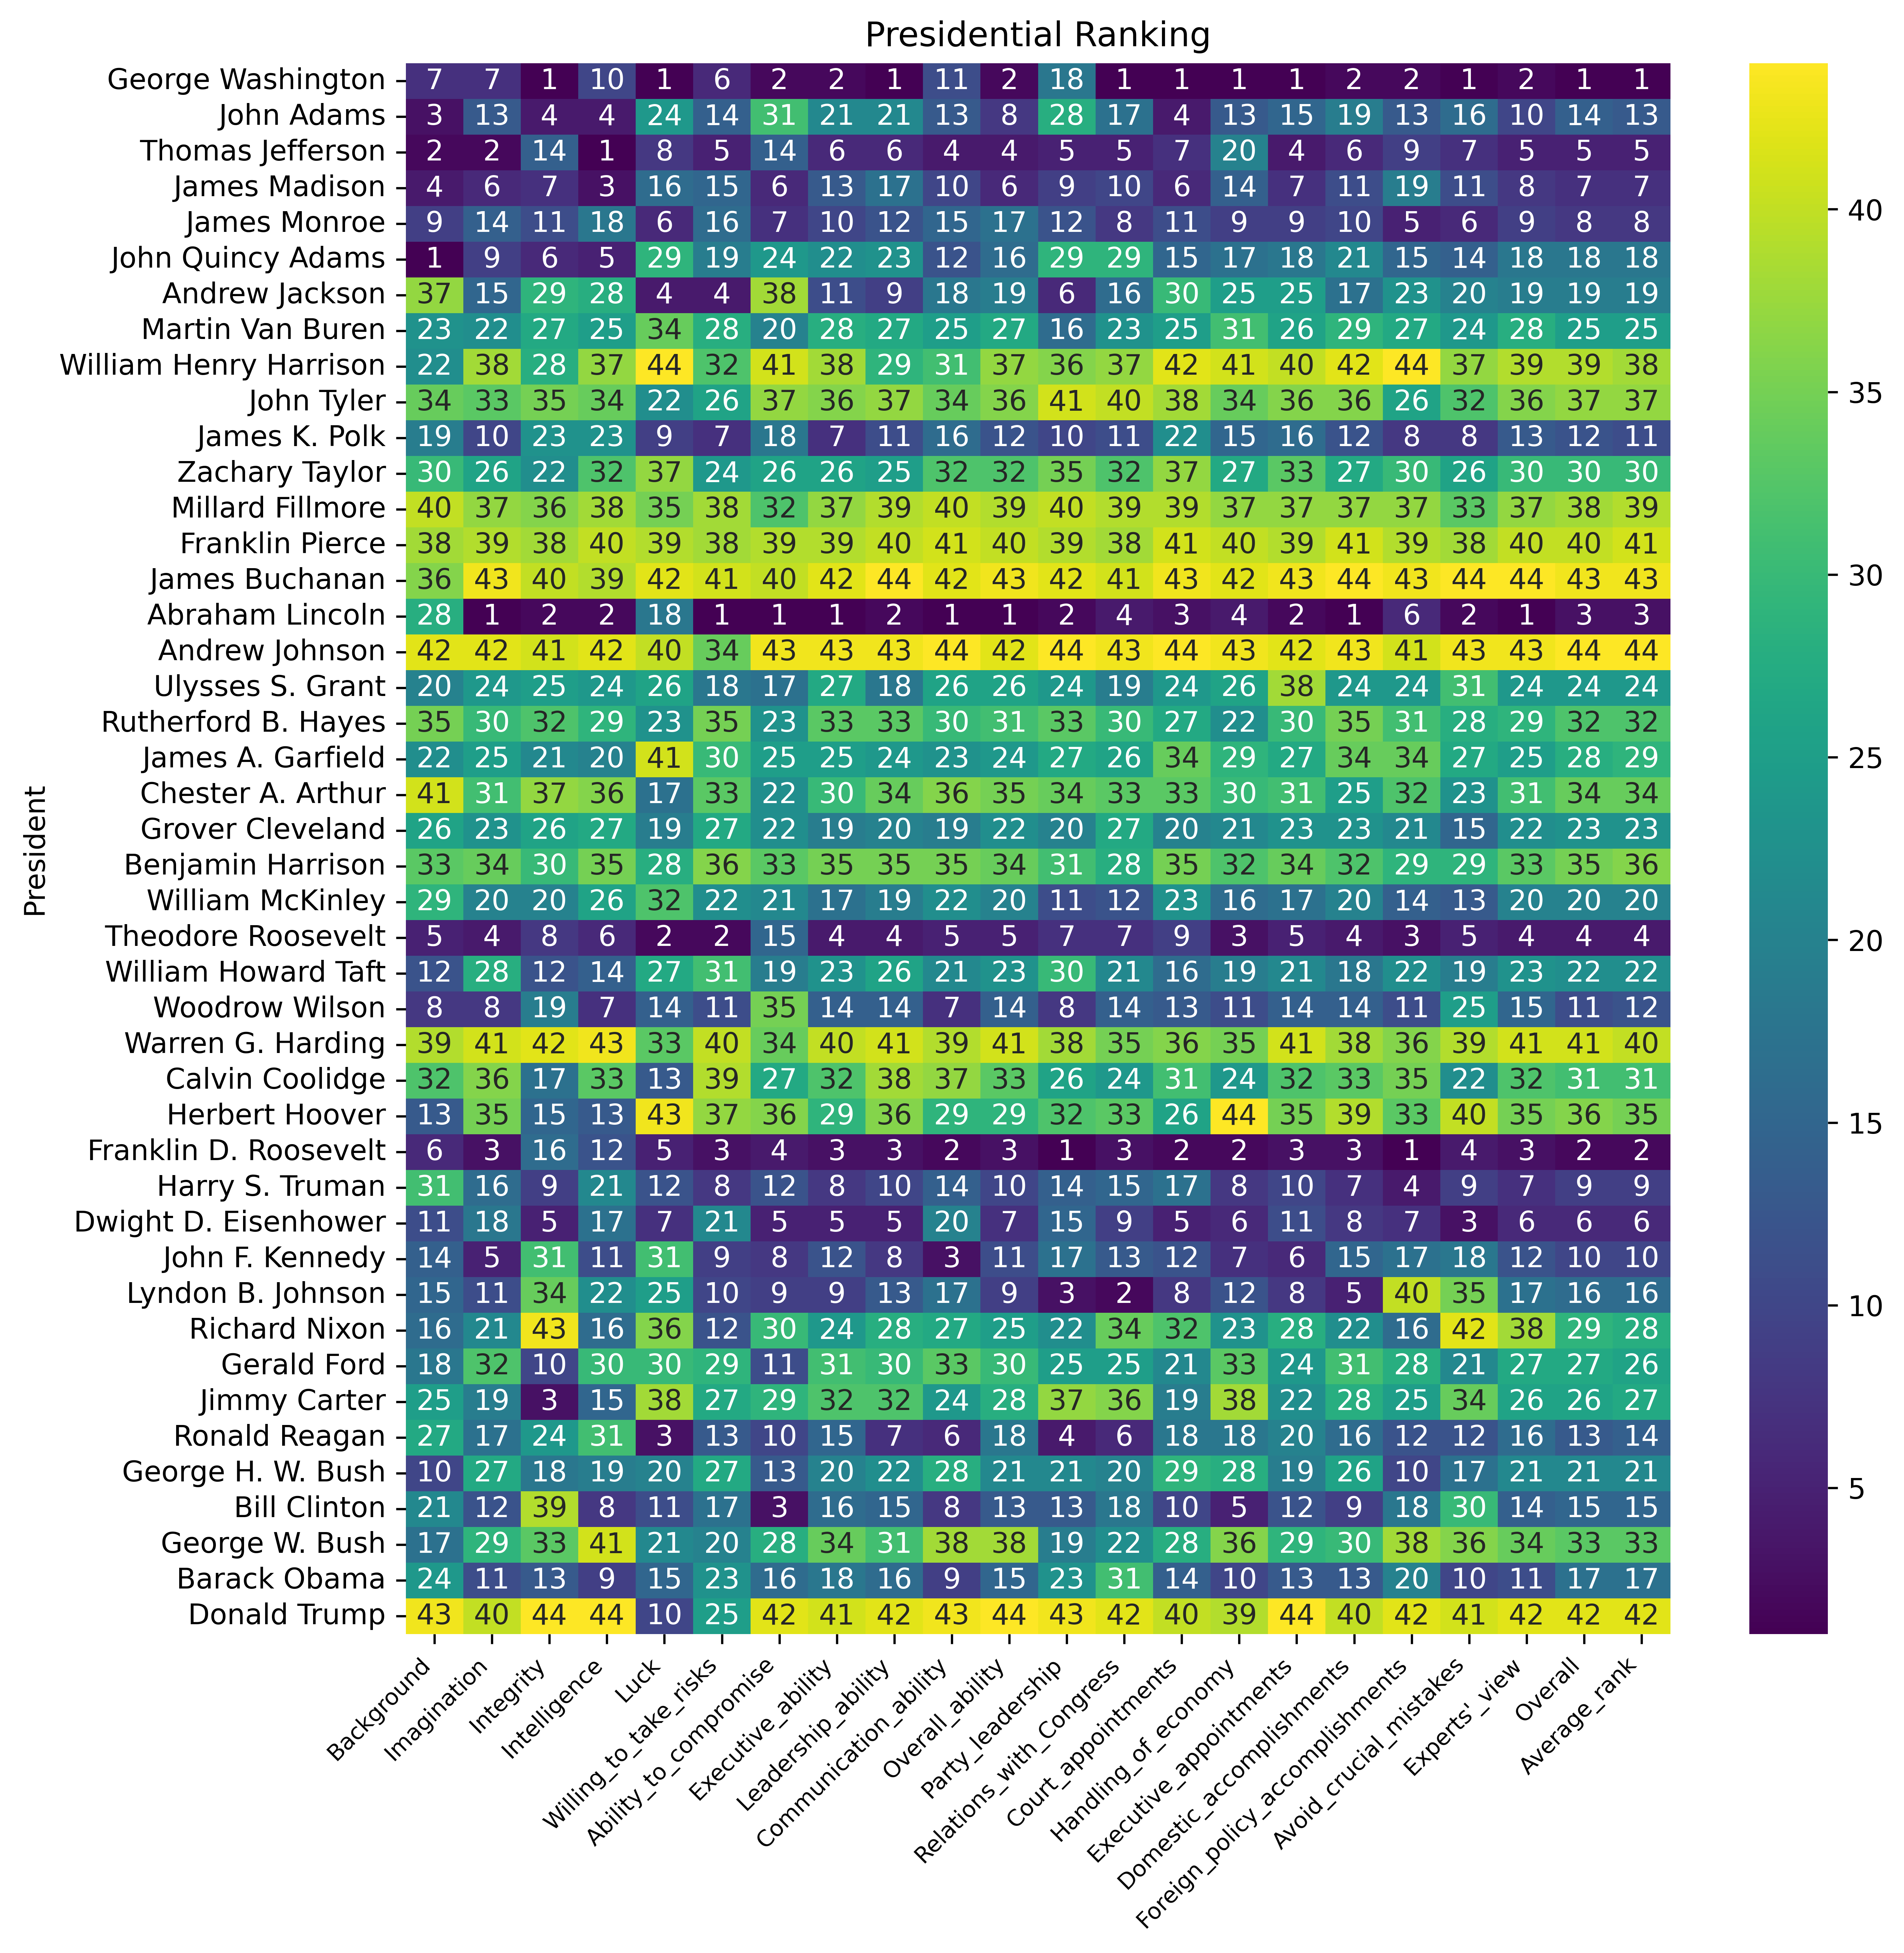

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10), dpi=600)
g = sns.heatmap((tweak_siena_pres(df)     # doctest: +SKIP
   .set_index('President')
   .iloc[:,2:-1]
  ),annot=True, cmap='viridis', ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, fontsize=8,
    ha='right')    # doctest: +SKIP
_ = plt.title('Presidential Ranking')
#fig.savefig('img/pandas2/20-pres.png', bbox_inches='tight')       # doctest: +SKIP